In [260]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from queue import PriorityQueue


In [261]:
print("hello world")

hello world


In [262]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights (inferred from image)
edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),

    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),

    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),

    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),

    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),

    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),

    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]

# Add edges to the graph
G.add_edges_from(edges)

# Print nodes and edges
print("Nodes:", G.nodes())
print("Edges:")
for u, v, attr in G.edges(data=True):
    print(f"{u} -> {v}, weights: user={attr['user']}, root={attr['root']}")


Nodes: ['Attacker', 'Pad', 'Web Server', 'Host 1', 'Host 2', 'Host 3', 'File Server', 'Data Server']
Edges:
Attacker -> Pad, weights: user=0.6, root=0.6
Attacker -> Web Server, weights: user=0.8, root=0.6
Attacker -> Host 1, weights: user=0.6, root=0.48
Pad -> Host 1, weights: user=0.6, root=0.48
Pad -> Host 2, weights: user=0.32, root=0.32
Pad -> Host 3, weights: user=0.32, root=0.32
Pad -> Web Server, weights: user=0.8, root=0.6
Web Server -> File Server, weights: user=0.8, root=0.04
Web Server -> Data Server, weights: user=0.8, root=0.04
Host 1 -> Pad, weights: user=0.6, root=0.6
Host 1 -> Web Server, weights: user=0.8, root=0.6
Host 1 -> Host 2, weights: user=0.32, root=0.32
Host 1 -> Host 3, weights: user=0.32, root=0.32
Host 2 -> Host 3, weights: user=0.8, root=0.8
Host 2 -> File Server, weights: user=0.8, root=0.6
Host 2 -> Data Server, weights: user=0.8, root=0.6
Host 3 -> Host 2, weights: user=0.8, root=0.8
Host 3 -> File Server, weights: user=0.8, root=0.6
Host 3 -> Data Serv

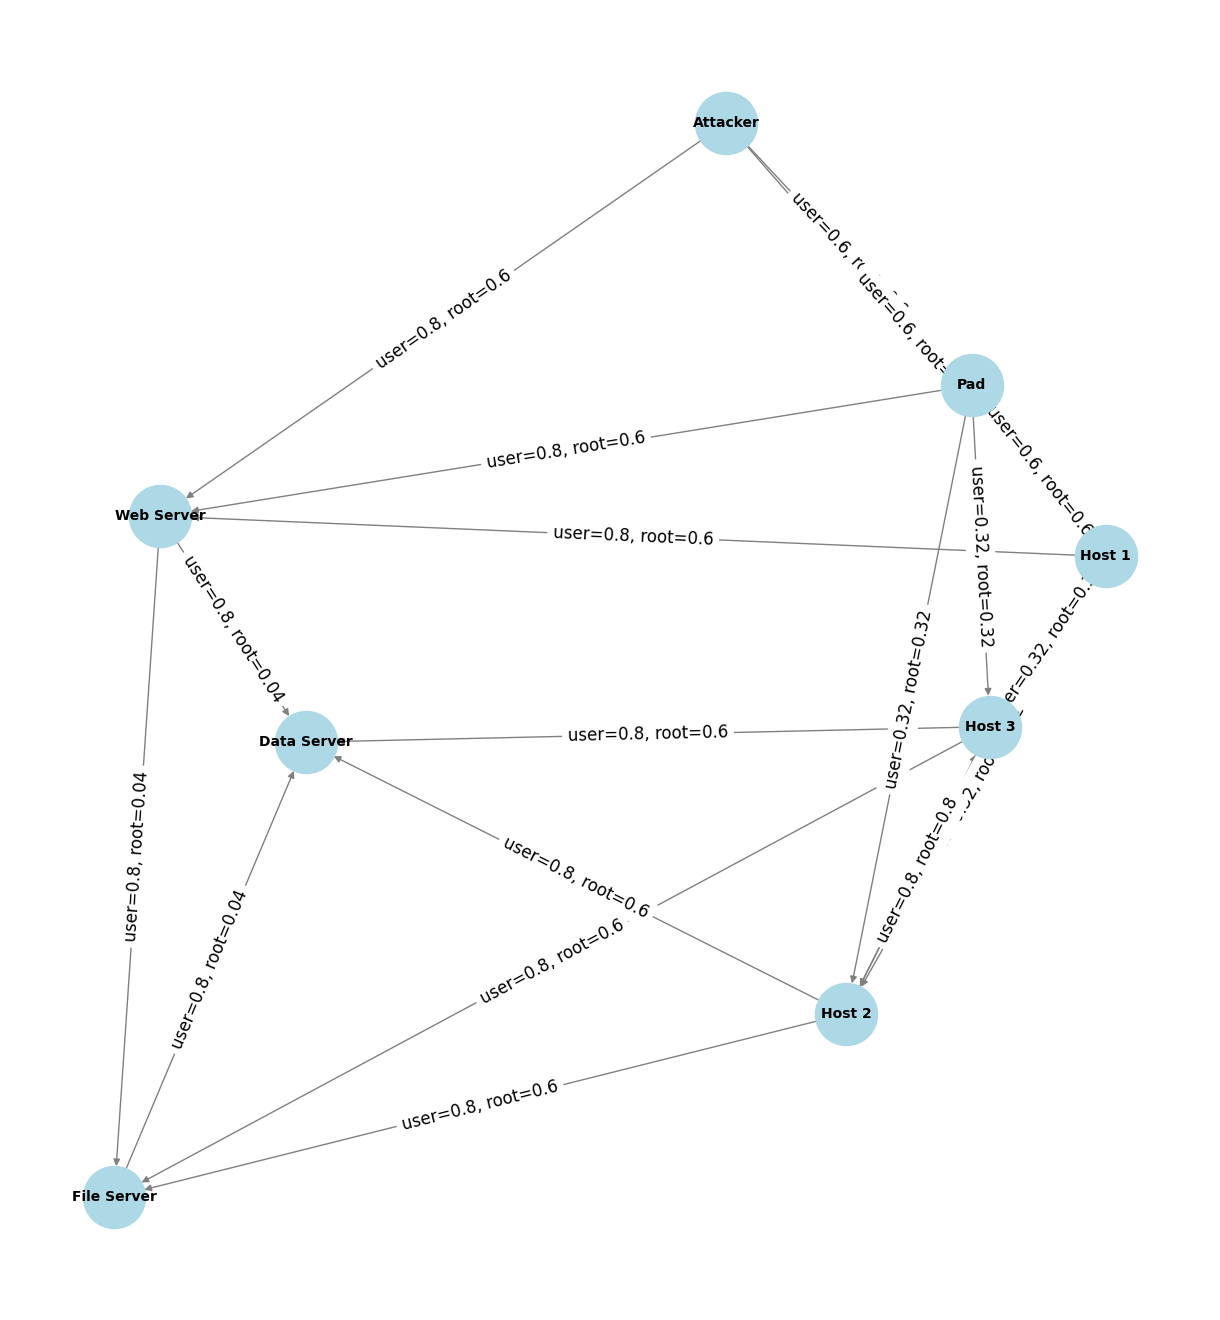

In [263]:

# Draw the graph
plt.figure(figsize=(12, 13))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10, font_weight='bold')

# Draw edge labels with weights
edge_labels = {(u, v): f"user={d['user']}, root={d['root']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.show()

In [264]:
def greedy_path_max(graph, start, goal):
    # Build a list of network nodes excluding the attacker
    node_list = [node for node in graph.nodes() if node != start]
    visited_vector = [0] * len(node_list)

    path = [start]
    current = start

    while current != goal:
        neighbors = list(graph.successors(current))
        if not neighbors:
            print("No path to goal found.")
            return path, visited_vector

        # Choose the neighbor with the highest max(user, root)
        next_node = max(
            neighbors,
            key=lambda n: max(graph[current][n]['user'], graph[current][n]['root'])
        )
        current = next_node
        path.append(current)

        # Mark as visited only if it's not the attacker
        if current != start:
            idx = node_list.index(current)
            if visited_vector[idx] == 1:
                print("Cycle detected. Breaking.")
                break
            visited_vector[idx] = 1

    return path, visited_vector, node_list

# Run it
path, visit_vector, tracked_nodes = greedy_path_max(G, "Attacker", "Data Server")

# Print results
print("Greedy path using max(user, root):")
print(" -> ".join(path))

print("\nVisited node vector:")
for node, visited in zip(tracked_nodes, visit_vector):
    print(f"{node}: {visited}")

Greedy path using max(user, root):
Attacker -> Web Server -> File Server -> Data Server

Visited node vector:
Pad: 0
Web Server: 1
Host 1: 0
Host 2: 0
Host 3: 0
File Server: 1
Data Server: 1


In [265]:
# Node indexing (excluding Attacker for state array)
nodes = [node for node in G.nodes() if node != "Attacker"]
num_nodes = len(nodes)
node_to_idx = {node: idx for idx, node in enumerate(nodes)}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}
graph_node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}  # Including Attacker for graph operations

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration rate
num_episodes = 1000
max_honeypots = 2

# Initialize Q-table (state is hashed array, action is honeypot placement)
Q = np.zeros((2**num_nodes, num_nodes))

# Hash state array to index
def state_to_index(state):
    return int("".join(map(str, state)), 2)

# Attacker's greedy attack with goal
def greedy_attack_priority_queue(graph, start, honeypots, goal):
    captured = {start}
    path = [start]
    pq = PriorityQueue()

    # Sort neighbors by weight descending, then node name for determinism
    neighbors = list(graph.successors(start))
    neighbors.sort(key=lambda n: (-max(graph[start][n]['user'], graph[start][n]['root']), n))

    # Debug: Log neighbor weights
    # if start == "Attacker":
    #     print(f"From {start}, neighbors: {[(n, max(graph[start][n]['user'], graph[start][n]['root'])) for n in neighbors]}")

    for neighbor in neighbors:
        weight = max(graph[start][neighbor]['user'], graph[start][neighbor]['root'])
        pq.put((-weight, neighbor))

    while not pq.empty():
        neg_weight, to_node = pq.get()
        weight = -neg_weight
        from_node = path[-1]  # Last node in path
        # Debug: Log choice
        # print(f"Dequeued {from_node} -> {to_node} with weight {weight}")

        captured.add(to_node)
        if to_node in honeypots:
            path.append(to_node)
            # print(f"Hit honeypot at {to_node}, stopping.")
            break
        if to_node not in captured:

            path.append(to_node)
            # print(f"Captured {to_node}")
            if to_node == goal:
                # print(f"Reached goal {goal}, stopping.")
                break
            # Sort neighbors for determinism
            neighbors = list(graph.successors(to_node))
            neighbors.sort(key=lambda n: (-max(graph[to_node][n]['user'], graph[to_node][n]['root']), n))
            for next_node in neighbors:
                if next_node not in captured:
                    next_weight = max(graph[to_node][next_node]['user'], graph[to_node][next_node]['root'])
                    pq.put((-next_weight, next_node))
    return path, captured
# Get possible honeypot placements
def get_possible_honeypot_actions(honeypots):
    return [node for node in nodes if node not in honeypots and node != "Data Server"]

# Reward function (updated)
def get_reward(path, goal, honeypots):
    if any(node in honeypots for node in path):
        return 1  # Attacker hits a honeypot
    if goal in path:
        return -1  # Attacker reaches Data Server
    return 0  # Neither honeypot nor goal reached

# Choose action (place honeypot)
def choose_action(state, honeypots, Q):
    possible_actions = get_possible_honeypot_actions(honeypots)
    if not possible_actions:
        return None

    state_idx = state_to_index(state)
    if random.uniform(0, 1) < epsilon:
        return random.choice(possible_actions)
    else:
        q_values = [Q[state_idx][node_to_idx[node]] for node in possible_actions]
        best_action_idx = np.argmax(q_values)
        return possible_actions[best_action_idx]

# Q-learning training
initial_state = [0] * num_nodes  # All zeros
previous_attack_state = initial_state.copy()

for episode in range(num_episodes):
    honeypots = set()
    state = initial_state.copy()  # Start fresh each episode

    for _ in range(max_honeypots):
        # Choose honeypot placement
        action = choose_action(state, honeypots, Q)
        if action is None:
            break

        honeypots.add(action)
        action_idx = node_to_idx[action]

        # Simulate attack
        attack_path, attack_captured = greedy_attack_priority_queue(G, "Attacker", honeypots, "Data Server")

        # Update state based on attack
        new_state = [0] * num_nodes
        for node in attack_path:
            if node != "Attacker" and node not in honeypots:  # Exclude honeypots from attacked state
                new_state[node_to_idx[node]] = 1

        # Calculate reward
        reward = get_reward(attack_path, "Data Server", honeypots)

        # Update Q-value using previous attack state
        state_idx = state_to_index(previous_attack_state)
        new_state_idx = state_to_index(new_state)
        best_next_q = np.max(Q[new_state_idx]) if get_possible_honeypot_actions(honeypots) else 0
        Q[state_idx][action_idx] += alpha * (reward + gamma * best_next_q - Q[state_idx][action_idx])

        # Update state for next iteration within episode
        state = new_state

    # Store attack state for next episode's learning
    previous_attack_state = state

# Extract optimal honeypot placement
def get_optimal_honeypots(Q):
    state = [0] * num_nodes
    honeypots = []

    for _ in range(max_honeypots):
        action = choose_action(state, set(honeypots), Q)
        if action is None:
            break
        honeypots.append(action)
        honeypots_set = set(honeypots)
        attack_path, _ = greedy_attack_priority_queue(G, "Attacker", honeypots_set, "Data Server")
        new_state = [0] * num_nodes
        for node in attack_path:
            if node != "Attacker" and node not in honeypots:
                new_state[node_to_idx[node]] = 1
        state = new_state

    return honeypots

In [266]:
# Test and print results
optimal_honeypots = get_optimal_honeypots(Q)
print("Optimal honeypot placements:", optimal_honeypots)
attack_path, attack_captured = greedy_attack_priority_queue(G, "Attacker", set(optimal_honeypots), "Data Server")
print("Attacker's path with honeypots:", " -> ".join(attack_path))
print("Nodes captured by attacker:", sorted(attack_captured))
print("State array after attack:", [1 if node in attack_captured and node != "Attacker" else 0 for node in nodes])

# Print Q-values for insight
print("\nQ-values for honeypot placements (summed over states):")
incoming_q = np.sum(Q, axis=0)
for idx, q_value in enumerate(incoming_q):
    print(f"- {idx_to_node[idx]}: {q_value:.4f}")

Optimal honeypot placements: ['Pad', 'Host 2']
Attacker's path with honeypots: Attacker -> Pad
Nodes captured by attacker: ['Attacker', 'Host 1', 'Pad', 'Web Server']
State array after attack: [1, 1, 1, 0, 0, 0, 0]

Q-values for honeypot placements (summed over states):
- Pad: 9.9995
- Web Server: 9.9994
- Host 1: 9.9895
- Host 2: 9.5374
- Host 3: 9.5907
- File Server: 9.5602
- Data Server: 0.0000
